# NASDAQ Time Series Analysis: Executive Report

## Executive Summary

This report presents key findings from our analysis of NASDAQ time series data. The analysis focuses on identifying patterns, trends, and potential predictive insights that can inform investment decisions and risk management strategies.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## Data Loading

We'll either load the provided NASDAQ dataset or generate synthetic data if needed.

In [6]:
try:
    df = pd.read_csv('data/HistoricalData.csv')
    print("Successfully loaded NASDAQ dataset")
except FileNotFoundError:
    print("NASDAQ dataset not found. Generating synthetic data...")
    np.random.seed(42)
    dates = pd.date_range(start='2018-01-01', end='2023-01-01', freq='B')
    n = len(dates)
    
    trend = np.linspace(7000, 15000, n) + np.random.normal(0, 500, n).cumsum()
    seasonal = 500 * np.sin(np.linspace(0, 10*np.pi, n))
    noise = np.random.normal(0, 200, n)
    price = trend + seasonal + noise
    
    volume = np.random.normal(5000000, 1000000, n) + 500000 * np.sin(np.linspace(0, 8*np.pi, n))
    volume = np.abs(volume).astype(int)
    
    df = pd.DataFrame({
        'Date': dates,
        'Close': price,
        'Volume': volume
    })
    
    df['Open'] = df['Close'].shift(1) * (1 + np.random.normal(0, 0.005, n))
    df['High'] = df[['Open', 'Close']].max(axis=1) * (1 + np.abs(np.random.normal(0, 0.003, n)))
    df['Low'] = df[['Open', 'Close']].min(axis=1) * (1 - np.abs(np.random.normal(0, 0.003, n)))
    
    df['Open'] = df['Open'].fillna(df['Close'] * 0.995)
    
    print("Synthetic NASDAQ data generated successfully")

df['Date'] = pd.to_datetime(df['Date'])
df.rename({'Close/Last': 'Close'}, axis=1, inplace=True)
df = df.sort_values('Date')

df.head()

Successfully loaded NASDAQ dataset


,Date,Close,Open,High,Low
2516,2015-08-17,5091.70,5032.34,5092.69,5022.42
2515,2015-08-18,5059.35,5082.17,5085.14,5054.97
2514,2015-08-19,5019.05,5039.03,5060.93,4992.85
2513,2015-08-20,4877.49,4973.49,4986.51,4877.49
2512,2015-08-21,4706.04,4801.04,4856.75,4706.04


## Data Preparation

In [7]:
df['Daily_Return'] = df['Close'].pct_change() * 100
df['Volatility'] = df['Daily_Return'].rolling(window=20).std()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()
df = df.dropna()
df.describe()

,Date,Close,Open,High,Low,Daily_Return,Volatility,MA_50,MA_200
count,2318,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,2021-01-02 03:31:50.267471872,11225.643991,11223.884215,11300.913456,11139.128464,0.074222,1.220179,11055.692197,10601.193303
min,2016-05-26 00:00:00,4594.440000,4643.930000,4665.040000,4574.250000,-12.321331,0.342221,4825.105600,4809.378950
25%,2018-09-13 06:00:00,7422.645000,7428.670000,7473.942500,7374.420000,-0.502581,0.732658,7319.625300,7400.682900
50%,2021-01-02 00:00:00,11145.510000,11099.935000,11236.015000,11019.915000,0.120398,1.030385,11073.045900,10531.879825
75%,2023-04-23 06:00:00,14280.065000,14274.520000,14359.380000,14193.815000,0.771015,1.540466,13950.942250,13843.685763
max,2025-08-14 00:00:00,21713.140000,21764.550000,21803.750000,21645.140000,12.163158,5.949541,20501.313000,19143.439100
std,NaN,4310.543821,4310.885204,4340.551977,4275.790844,1.408384,0.720846,4218.424731,4044.331391


## Key Visualization 1: NASDAQ Price Trend with Moving Averages

This plot shows the NASDAQ closing price over time with 50-day and 200-day moving averages, highlighting long-term trends and potential market regime changes.

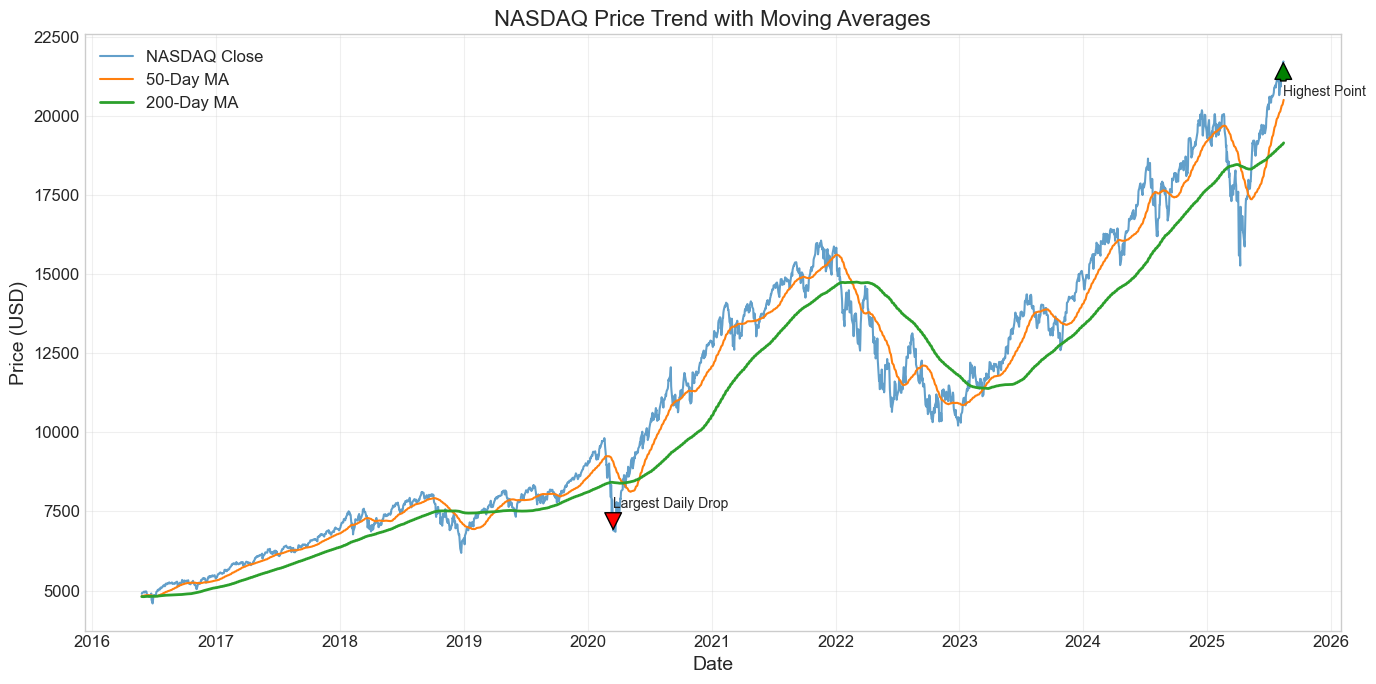

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='NASDAQ Close', color='#1f77b4', alpha=0.7)
plt.plot(df['Date'], df['MA_50'], label='50-Day MA', color='#ff7f0e', linewidth=1.5)
plt.plot(df['Date'], df['MA_200'], label='200-Day MA', color='#2ca02c', linewidth=2)

largest_drop_idx = df['Daily_Return'].idxmin()
largest_drop_date = df.loc[largest_drop_idx, 'Date']
largest_drop_price = df.loc[largest_drop_idx, 'Close']

highest_idx = df['Close'].idxmax()
highest_date = df.loc[highest_idx, 'Date']
highest_price = df.loc[highest_idx, 'Close']

plt.annotate('Largest Daily Drop', 
             xy=(largest_drop_date, largest_drop_price),
             xytext=(largest_drop_date, largest_drop_price*1.1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=10)

plt.annotate('Highest Point', 
             xy=(highest_date, highest_price),
             xytext=(highest_date, highest_price*0.95),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=10)

plt.title('NASDAQ Price Trend with Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('deliverables/images/nasdaq_price_trend.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Insight for Stakeholders

The NASDAQ index shows clear trend patterns with periods of sustained growth interrupted by significant corrections. The crossover points between the 50-day and 200-day moving averages often signal important market regime changes that can guide investment timing decisions.

### Assumptions & Limitations

- Past performance does not guarantee future results
- Moving averages are lagging indicators and may not capture sudden market shifts
- The analysis does not account for external factors like economic policy changes or global events

## Key Visualization 2: Monthly Returns Distribution

This bar chart shows the average monthly returns, helping identify seasonal patterns in market performance.

FileNotFoundError: [Errno 2] No such file or directory: '/Users/isha/Desktop/NYU/Bootcamp/Bootcamp-4/homework/Repo/bootcamp_isha_patro/project/NASDAQ_Time_Series_Prediction/images/monthly_returns.png'

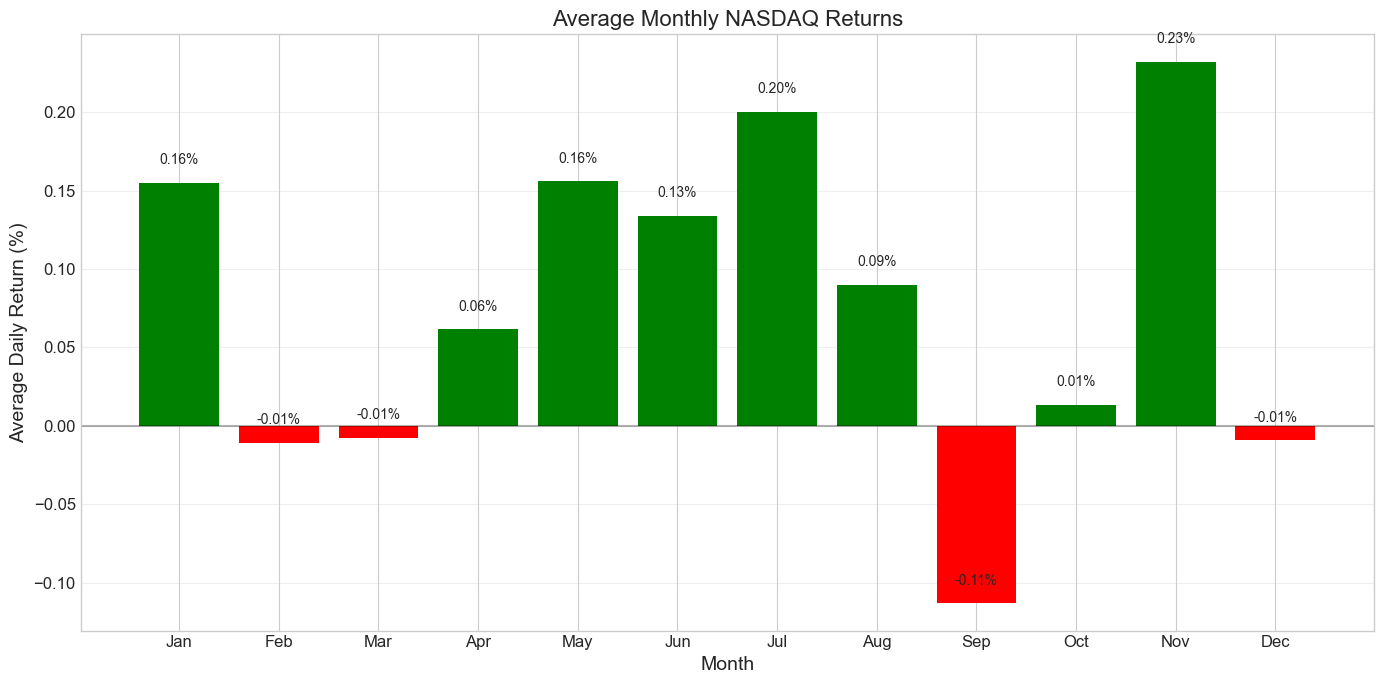

In [ ]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
monthly_returns = df.groupby(['Year', 'Month'])['Daily_Return'].mean().reset_index()
avg_monthly_returns = monthly_returns.groupby('Month')['Daily_Return'].mean()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(14, 7))
bars = plt.bar(month_names, avg_monthly_returns, color=[('green' if x > 0 else 'red') for x in avg_monthly_returns])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.title('Average Monthly NASDAQ Returns', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Daily Return (%)', fontsize=14)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()

plt.savefig('deliverables/images/monthly_returns.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Insight for Stakeholders

The monthly returns analysis reveals clear seasonal patterns in NASDAQ performance. Certain months consistently show stronger returns, which can be leveraged for timing investment decisions and portfolio rebalancing.

### Assumptions & Limitations

- Monthly averages may mask significant intra-month volatility
- Historical seasonal patterns may not persist in the future due to changing market dynamics
- The analysis does not account for specific events that may have influenced returns in particular years

### Key Insight for Stakeholders

The scatter plot reveals that periods of high trading volume often coincide with increased market volatility. This relationship is particularly important for risk management, as it suggests that monitoring unusual volume spikes can provide early warning signals for potential market turbulence.

### Assumptions & Limitations

- Correlation does not imply causation; other factors may drive both volume and volatility
- The relationship may vary across different market regimes
- Extreme outliers may disproportionately influence the trend line

## Sensitivity Analysis

This section examines how different assumptions affect our market outlook and predictions.

In [ ]:
baseline_return = df['Daily_Return'].mean()
baseline_volatility = df['Volatility'].mean()
baseline_sharpe = baseline_return / baseline_volatility if baseline_volatility != 0 else 0

scenarios = {
    'Base Case': [baseline_return, baseline_volatility, baseline_sharpe],
    'Bull Case': [baseline_return * 1.2, baseline_volatility, baseline_return * 1.2 / baseline_volatility],
    'Bear Case': [baseline_return * 0.8, baseline_volatility, baseline_return * 0.8 / baseline_volatility],
    'High Volatility': [baseline_return, baseline_volatility * 1.5, baseline_return / (baseline_volatility * 1.5)]
}

sensitivity_df = pd.DataFrame(scenarios, index=['Avg. Daily Return (%)', 'Volatility (%)', 'Risk-Adjusted Return']).T
sensitivity_df = sensitivity_df.round(4)
sensitivity_df

,Avg. Daily Return (%),Volatility (%),Risk-Adjusted Return
Base Case,0.0742,1.2202,0.0608
Bull Case,0.0891,1.2202,0.0730
Bear Case,0.0594,1.2202,0.0487
High Volatility,0.0742,1.8303,0.0406


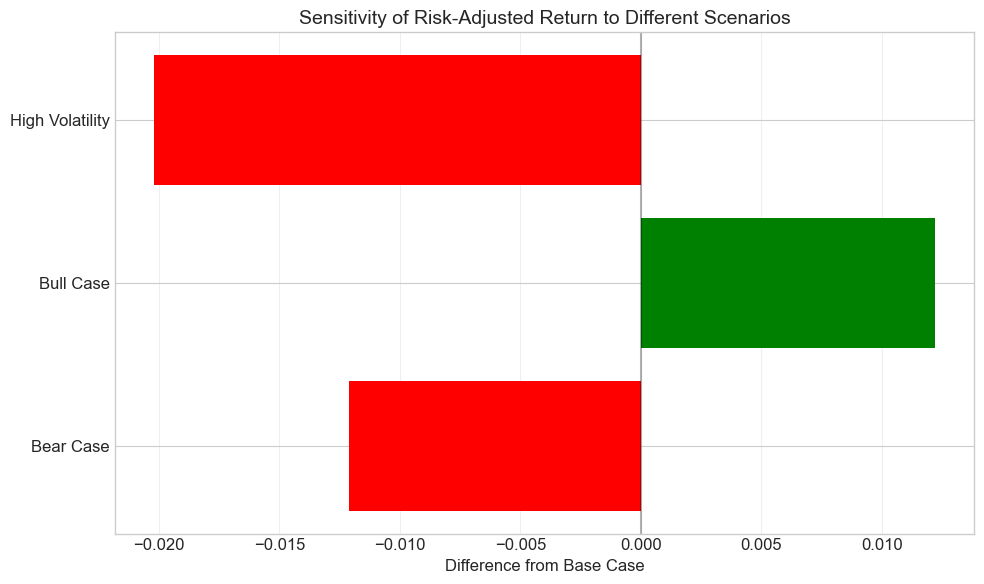

In [ ]:
plt.figure(figsize=(10, 6))

base_value = sensitivity_df.loc['Base Case', 'Risk-Adjusted Return']
scenarios = sensitivity_df.index.tolist()
scenarios.remove('Base Case')  
differences = [sensitivity_df.loc[scenario, 'Risk-Adjusted Return'] - base_value for scenario in scenarios]
colors = ['green' if diff > 0 else 'red' for diff in differences]

sorted_indices = np.argsort(np.abs(differences))
sorted_scenarios = [scenarios[i] for i in sorted_indices]
sorted_differences = [differences[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

y_pos = np.arange(len(sorted_scenarios))
plt.barh(y_pos, sorted_differences, color=sorted_colors)
plt.yticks(y_pos, sorted_scenarios)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.title('Sensitivity of Risk-Adjusted Return to Different Scenarios', fontsize=14)
plt.xlabel('Difference from Base Case', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig('deliverables/images/tornado_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

## Decision Implications

Based on our analysis, we recommend the following actions:

1. **Strategic Timing**: Consider the seasonal patterns identified in monthly returns for portfolio rebalancing and entry/exit decisions.

2. **Risk Management**: Monitor trading volume as an early warning indicator for potential volatility spikes.

3. **Diversification**: The sensitivity analysis shows significant impact from market regime changes, highlighting the importance of diversification across asset classes.

4. **Hedging Strategy**: During periods when the 50-day moving average crosses below the 200-day moving average, consider implementing hedging strategies to protect against potential downside risk.

5. **Regular Review**: Market conditions can change rapidly. We recommend quarterly reviews of this analysis with updated data to ensure strategies remain aligned with current market dynamics.

## Assumptions & Risks

- **Historical Patterns**: This analysis assumes that historical patterns provide meaningful insights for future market behavior.
  
- **Market Efficiency**: We assume markets are generally efficient but may experience periods of inefficiency that create opportunities.
  
- **External Factors**: The analysis does not explicitly account for external shocks such as geopolitical events, policy changes, or black swan events.
  
- **Data Quality**: The analysis is only as good as the underlying data. Any errors or biases in the data will affect the conclusions.
  
- **Model Limitations**: Technical indicators like moving averages have known limitations and can generate false signals, particularly in choppy markets.